# Shifting moons with dynamic rotation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import optax
import dojax
import jax.numpy as jnp
import flax.linen as nn
import pandas as pd

import matplotlib.pyplot as plt

from celluloid import Camera
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [4]:
X, y = make_moons(n_samples=100, noise=0.12, random_state=314)

In [5]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(30)(x))
        x = nn.relu(nn.Dense(30, name="last_layer")(x))
        x = nn.Dense(1)(x)
        x = nn.sigmoid(x)
        return x

In [6]:
model = MLP()
loss = dojax.make_mse_func(model, X, y)

batch = jnp.ones((1, 2))
key = jax.random.PRNGKey(314)
params = model.init(key, batch)

alpha = 0.1
tx = optax.adam(learning_rate=alpha)

opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

In [7]:
for i in range(201):
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 50 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  0.09936693
Loss step 50:  0.0002880705
Loss step 100:  5.81348e-06
Loss step 150:  3.87713e-06
Loss step 200:  3.0246852e-06


## Multiple

In [8]:
def estimate_weights(model, X, y, key, optimizer, n_epochs=200, seed=None, output_progress=False, print_final_loss=False):
    loss = dojax.make_mse_func(model, X, y)
    batch = jnp.ones((1, 2))
    params = model.init(key, batch)
    opt_state = optimizer.init(params)
    loss_grad_fn = jax.value_and_grad(loss)
    
    for i in range(n_epochs):
        loss_val, grads = loss_grad_fn(params)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        if i % 50 == 0 and output_progress:
            print('Loss step {}: '.format(i), loss_val)
    if print_final_loss:
        print(f"Final loss: {loss_val}")
        
    output = {
        "params": params,
        "final_loss": loss_val,
        "train_accuracy": (model.apply(params, X).round().ravel() == y).mean()
    }
    
    return output

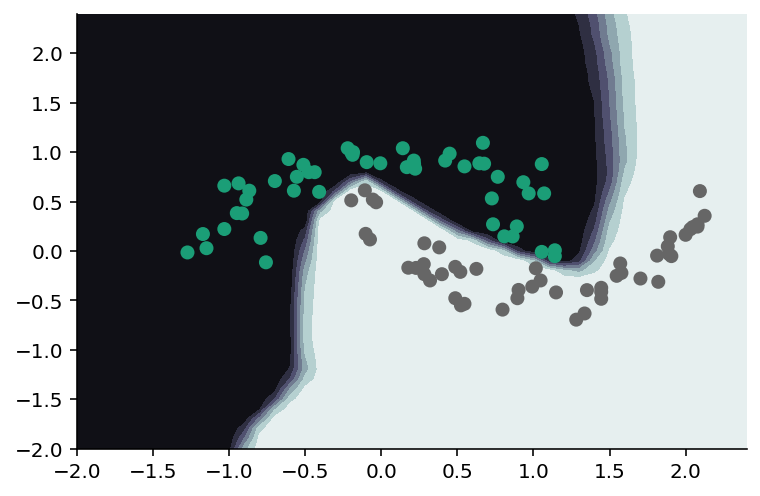

In [9]:
model = MLP()
alpha = 0.1
tx = optax.adam(learning_rate=alpha)

X, y = make_moons(n_samples=100, noise=0.12, random_state=314)
X = jnp.einsum("nm,mk->nk", X, dojax.rotation_matrix(0))
res = estimate_weights(model, X, y, key, tx)
params = res["params"]
params_flat, _ = jax.flatten_util.ravel_pytree(params)

pred_map = jax.vmap(model.apply, (None, 1))
pred_map = jax.vmap(pred_map, (None, 2))

X_grid = jnp.mgrid[-2:2.5:0.1, -2:2.5:0.1]
Z = jnp.einsum("ijn->ji", pred_map(params, X_grid))

plt.contourf(*X_grid, Z, cmap="bone")
plt.scatter(*X.T, c=y, cmap="Dark2")

## Weight's dynamics

In [10]:
def train_mlp_model(key, data_generator, model, optimiser, eval_elements,
                    n_epochs=200, centre=False, **kwargs):
    """
    Train an MLP model iterating over eval elements and applying each element to the
    data-gerating process.
    
    Parameters
    ----------
    data_generator: function
        Data generation function. It returns a tuple of
        X, y elements.
    model: Flax model
        The model to train the X and y elements.
    optimiser: Optax element
        Optimiser to train falx model
    eval_elements: array
        The range of values to iterate the model configuration
    n_epoch: int
        Number of epochs to train the model
    centre: Bool
        Whether to centre the data
    
    Returns
    -------
    dictionary
    """
    data_hist = []
    params_hist = []
    train_acc_hist = []
    
    n_elements = len(eval_elements)
    for it, val in enumerate(eval_elements):
        X, y = data_generator(val)
        
        X_train = X.copy()
        if centre:
            X_train = X_train - X_train.mean(axis=0, keepdims=True)
            
            
        res = estimate_weights(model, X_train, y, key, optimiser, n_epochs=n_epochs)
        
        params = res["params"]
        loss = res["final_loss"]
        train_acc = res["train_accuracy"].item()
        
        
        data_hist.append([X, y])
        params_hist.append(params)
        train_acc_hist.append(train_acc)
        
        print(f"@it: {it+1:03}/{n_elements:03} || {loss=:0.4e}", end="\r")
    
    hist = {
        "data": data_hist,
        "params": params_hist,
        "train_accuracy": jnp.array(train_acc_hist)
    }
    
    return hist


def flat_and_concat_params(params_hist):
    """
    Flat and concat a list of parameters trained using
    a Flax model
    
    
    Parameters
    ----------
    params_hist: list of flax FrozenDicts
        List of flax FrozenDicts containing trained model
        weights.
    
    Returns
    -------
    jnp.array: flattened and concatenated weights
    """
    flat_params = [jax.flatten_util.ravel_pytree(params)[0] for params in params_hist]
    flat_params  = jnp.r_[flat_params]
    return flat_params



def make_rotating_moons(radians, n_samples=100, **kwargs):
    """
    Make two interleaving half circles rotated by 'radians' radians
    
    Parameters
    ----------
    radians: float
        Angle of rotation
    n_samples: int
        Number of samples
    **kwargs:
        Extra arguments passed to the `make_moons` function
    """
    X, y = make_moons(n_samples=n_samples, **kwargs)
    X = jnp.einsum("nm,mk->nk", X, dojax.rotation_matrix(radians))
    return X, y



def make_rotating_translating_moons(radians, n_samples=100, **kwargs):
    """
    Make two interleaving half circles rotated by 'radians' radians
    
    Parameters
    ----------
    radians: float
        Angle of rotation
    n_samples: int
        Number of samples
    **kwargs:
        Extra arguments passed to the `make_moons` function
    """
    X, y = make_moons(n_samples=n_samples, **kwargs)
    # 1. rotate
    X = jnp.einsum("nm,mk->nk", X, dojax.rotation_matrix(radians))
    # 2. translate
    X = X + 4 * jnp.c_[jnp.cos(radians), jnp.sin(2 * radians)]
    return X, y

## Rotate

In [139]:
alpha = 0.05
n_steps = 200
model = MLP()

key = jax.random.PRNGKey(314)
tx = optax.adam(learning_rate=alpha)
radii = jnp.linspace(0, 2 * 2 * jnp.pi, n_steps)

In [140]:
hist = train_mlp_model(key, lambda rad: make_rotating_moons(rad, noise=0.2), model, tx, radii)
data_hist, params_hist = hist["data"], hist["params"]

In [141]:
import os
import pickle
from datetime import datetime

date_fmt = "%y%m%d%H%m"
date_str = datetime.now().strftime(date_fmt)

file_params_name = f"moons-rotating-params-{date_str}.pkl"
file_params_name = os.path.join("outputs", file_params_name)

file_dataset_name = f"moons-rotating-dataset-{date_str}.pkl"
file_dataset_name = os.path.join("outputs", file_dataset_name)

with open(file_params_name, "wb") as f:
    pickle.dump(params_hist, f)
    
with open(file_dataset_name, "wb") as f:
    pickle.dump(data_hist, f)

In [14]:
import pickle
file_name = "./outputs/moons-rotating-params-2203010703.pkl"
with open(file_name, "rb") as f:
    params_hist = pickle.load(f)

In [142]:
params_flat_hist = flat_and_concat_params(params_hist)

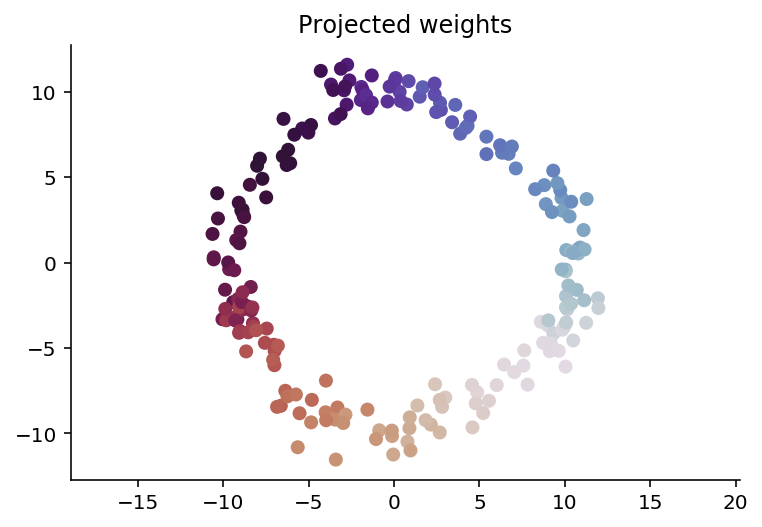

In [143]:
proj = PCA(n_components=2)
# proj = KernelPCA(n_components=2, kernel="cosine")
# proj = TSNE(n_components=2, init="pca", random_state=314, perplexity=10)
w_transformed = proj.fit_transform(params_flat_hist)

plt.title("Projected weights")
domain = radii % (2 * jnp.pi)
plt.scatter(*w_transformed.T, c=domain, cmap="twilight")
plt.axis("equal");

In [144]:
def plot_history(params_hist, data_hist, ranges):
    """
    Animate projected weight dynamics and observations
    
    Parameters
    ----------
    params_hist: list of FrozenDict
        List of trained weights
    data_hist: list of (array(N). 
    """
    ...

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
camera = Camera(fig)

xmin, xmax = -2, 2
ymin, ymax = -2, 2
X_grid = jnp.mgrid[xmin:xmax:0.1, ymin:ymax:0.1]

ax[0].set_title("Observation space")
ax[1].set_title("(projected) weight space")
for it in range(n_steps):
    # plt.cla()
    params = params_hist[it]
    X_step, y_step = data_hist[it]
    Z = jnp.einsum("ijn->ji", pred_map(params, X_grid))
    
    ax[1].scatter(*w_transformed[:it].T, c=radii[:it] % (2 * jnp.pi), cmap="twilight")
    ax[1].axis("equal")
    ax[0].contourf(*X_grid, Z, cmap="bone")
    ax[0].scatter(*X_step.T, c=y_step, cmap="Dark2")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    camera.snap()

animation = camera.animate()  
# animation.save('half-moons.gif', writer = 'imagemagick')
animation.save('half-moons.mp4', fps=20, dpi=150)

## Approximate projection

In this section, we investigate the effect of projecting the weights to a linear subspace and projecting them back to the full space using an approximate mapping.

In this test, we take $d$ number of components and 

In [94]:
def create_comparisson_df(model, projected_weights, full_weights, configurations, projection,
                          test_samples=100, seed=None):
    hist_values = []
    n_configurations = len(configurations)
    iterables = zip(configurations, projected_weights, full_weights)
    for ix, (config, w_proj, w_full) in enumerate(iterables):
        seed_ix = None if seed is None else seed + ix
        print(f"@it{ix+1:03}/{n_configurations}", end="\r")
        w_full_approx = projection.inverse_transform(w_proj)
        w_full_approx = rebuild_params(w_full_approx)
        
        X_test, y_test = make_rotating_moons(config, n_samples=test_samples, random_state=seed_ix)
        
        accuracy_full = (model.apply(w_full, X_test).round().ravel() == y_test).mean().item()
        accuracy_proj = (model.apply(w_full_approx, X_test).round().ravel() == y_test).mean().item()
        
        entry = {
            "radius": config.item(),
            "acc_full": accuracy_full,
            "acc_proj": accuracy_proj
        }
        
        hist_values.append(entry)
    hist_values = pd.DataFrame(hist_values).set_index("radius")
    return hist_values

In [97]:
n_components = 100
proj = PCA(n_components=n_components)
w_transformed = proj.fit_transform(params_flat_hist)
_, rebuild_params = jax.flatten_util.ravel_pytree(params_hist[0])

In [120]:
components = range(0, 210, 10)

errors = []
for n_components in components:
    n_components = 1 if n_components == 0 else n_components
    print(f"Evaluating component {n_components}")
    proj = PCA(n_components=n_components)
    w_transformed = proj.fit_transform(params_flat_hist)
    _, rebuild_params = jax.flatten_util.ravel_pytree(params_hist[0])
    hist_values = create_comparisson_df(model, w_transformed, params_hist, radii, proj)
    
    error = hist_values.diff(axis=1).dropna(axis=1)
    mean_abs_error = error.abs().mean().item()
    mean_error = error.mean().item()
    
    errors_entry = {
        "n_components": n_components,
        "mean_abs_error": mean_abs_error,
        "mean_error": mean_error
    }
    
    errors.append(errors_entry)
    
    print(f"{mean_abs_error=:0.4f}")
    print(f"{mean_error=:0.4f}", end="\n"*2)

Evaluating component 1
mean_abs_error=0.2529
mean_error=-0.2529

Evaluating component 10
mean_abs_error=0.0256
mean_error=-0.0219

Evaluating component 20
mean_abs_error=0.0210
mean_error=-0.0165

Evaluating component 30
mean_abs_error=0.0187
mean_error=-0.0139

Evaluating component 40
mean_abs_error=0.0189
mean_error=-0.0147

Evaluating component 50
mean_abs_error=0.0192
mean_error=-0.0153

Evaluating component 60
mean_abs_error=0.0197
mean_error=-0.0159

Evaluating component 70
mean_abs_error=0.0152
mean_error=-0.0121

Evaluating component 80
mean_abs_error=0.0160
mean_error=-0.0120

Evaluating component 90
mean_abs_error=0.0150
mean_error=-0.0111

Evaluating component 100
mean_abs_error=0.0145
mean_error=-0.0117

Evaluating component 110
mean_abs_error=0.0108
mean_error=-0.0076

Evaluating component 120
mean_abs_error=0.0091
mean_error=-0.0058

Evaluating component 130
mean_abs_error=0.0087
mean_error=-0.0052

Evaluating component 140
mean_abs_error=0.0054
mean_error=-0.0023

Evalua

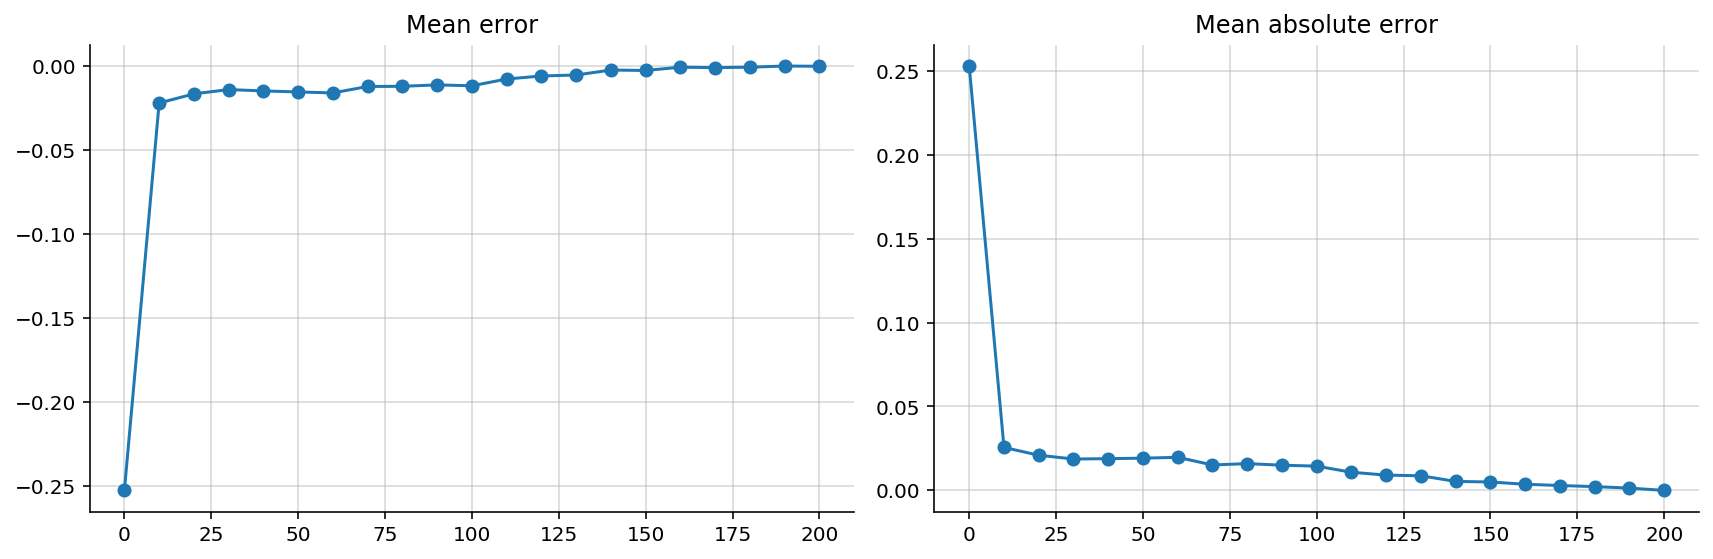

In [154]:
errors_df = pd.DataFrame(errors, index=components)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Mean error")
ax[1].set_title("Mean absolute error")

errors_df["mean_error"].plot(marker="o", ax=ax[0])
errors_df["mean_abs_error"].plot(marker="o", ax=ax[1])
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
plt.tight_layout()

In [87]:
hist_values = []

for ix, radius in enumerate(radii):
    print(f"@it{ix+1:03}/{len(radii)}", end="\r")
    deg = (180 * (radii[ix] % (2 * jnp.pi))).item()

    w_approx =  proj.inverse_transform(w_transformed[ix])
    w_approx = rebuild_params(w_approx)
    w_full = params_hist[ix]

    X_test, y_test = make_rotating_moons(radii[ix], n_samples=100)

    accuracy_proj = (model.apply(w_approx, X_test).round().ravel() == y_test).mean().item()
    accuracy_full = (model.apply(w_full, X_test).round().ravel() == y_test).mean().item()
    
    entry = {
        "radius": radius.item(),
        "accuracy_full": accuracy_full,
        "accuracy_approx": accuracy_proj,
    }
    
    hist_values.append(entry)
df_values = pd.DataFrame(hist_values).set_index("radius")

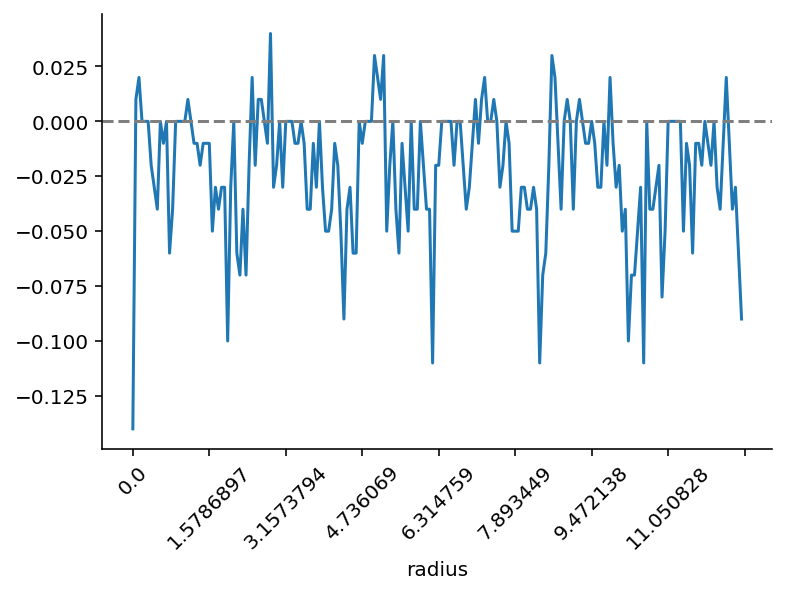

In [50]:
df_values = pd.DataFrame(hist_values).set_index("radius")
df_values.diff(axis=1).iloc[:, 1].plot()
plt.axhline(y=0, c="tab:gray", linestyle="--")
plt.xticks(rotation=45);

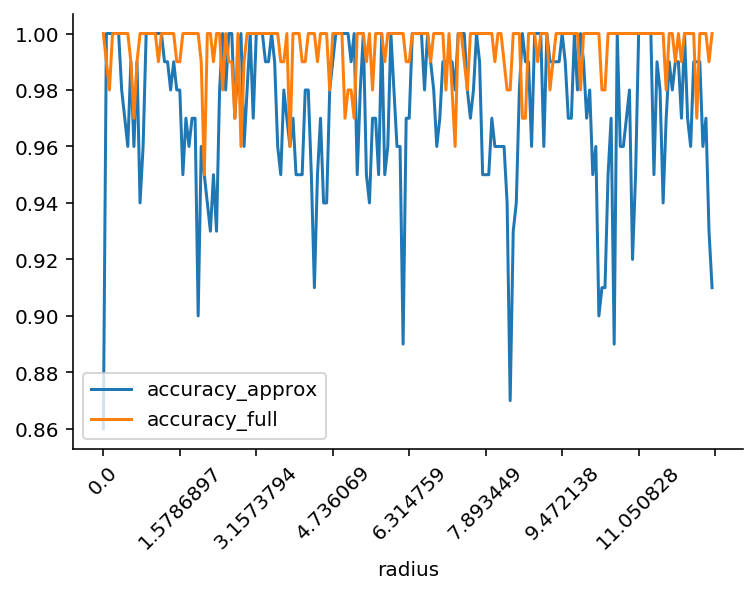

In [51]:
fig, ax = plt.subplots()

pd.DataFrame(hist_values).plot(x="radius", y="accuracy_approx", ax=ax)
pd.DataFrame(hist_values).plot(x="radius", y="accuracy_full", ax=ax)
plt.xticks(rotation=45);

## Rotate and shift

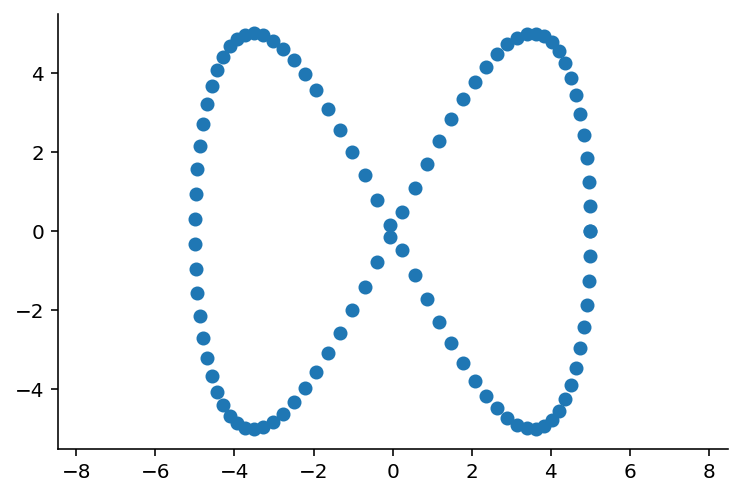

In [23]:
for r in jnp.linspace(0, 2 * jnp.pi, 100):
    x = 5 * jnp.cos(r)
    y = 5 * jnp.sin(2 * r)
    plt.scatter(x, y, c="tab:blue")
plt.axis("equal");

In [25]:
alpha = 0.01
n_steps = 200
model = MLP()

key = jax.random.PRNGKey(314)
tx = optax.adam(learning_rate=alpha)
radii = jnp.linspace(0, 2 * 2 * jnp.pi, n_steps)


def rotate_shift_centre():
    """
    """
    ...

hist = train_mlp_model(key, lambda rad: make_rotating_translating_moons(rad, noise=0.1),
                                         model, tx, radii, centre=True)
data_hist, params_hist = hist["data"], hist["params"]
params_flat_hist = flat_and_concat_params(params_hist)

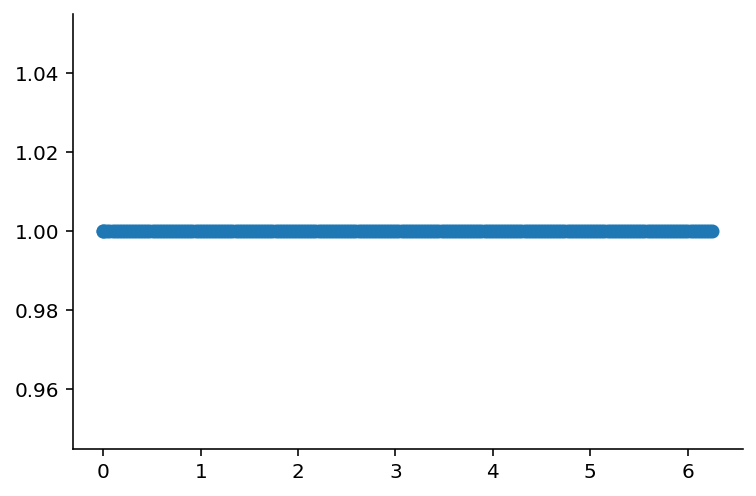

In [26]:
radii_mod = radii % (2 * jnp.pi)
plt.scatter(radii_mod, hist["train_accuracy"])

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(-15.462135744094848,
 16.920890283584594,
 -18.638972997665405,
 15.696493864059448)

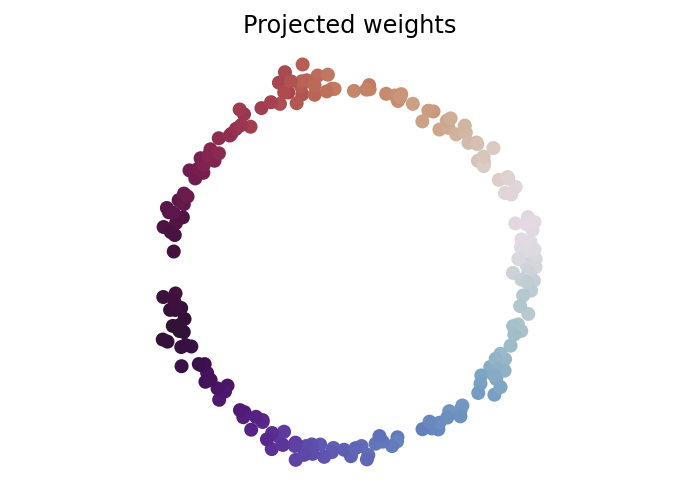

In [36]:
proj = PCA(n_components=2)
# proj = KernelPCA(n_components=2, kernel="cosine")
proj = TSNE(n_components=2, init="pca", random_state=314,
            perplexity=20, learning_rate="auto")
w_transformed = proj.fit_transform(params_flat_hist)

plt.title("Projected weights")
plt.scatter(*w_transformed.T, c=radii_mod, cmap="twilight")
plt.axis("equal")
plt.axis("off")

## Higher dimensions

Quickly adapting model. When corrupting, thing always on a way to uncorrupt.
* We can go from model A to model B in different ways (or paths). Think of driving in a car during the day and eventually going into night v.s. 
* How do we move to find a new datapoint? What triggers the switch to go find another model? Kevin suggested doing marginal likelihood test.
* We seek a highly adaptive model that is able to revisit a state if it needs to (remember)

* Distance in weight space.
* We can track distribution shift through the weights of NNet if the transformation is smooth.
* Neural generative models. Take VAE => Apply weights to the VAE.
* Conjectures: Neural architectures preserve the topology of the weight-space dynamics.
* Q: how to make the predictions? / how to choose the learned weights?

## ToDo

1. Dimensionality
2. Stochasticity
3. Abrupt changes

# * Increase dimensionality of points (20D/40D)
* Nonlinear transformation of points

1. Try transformation over MNIST dataset
2. Try _topological_ transformation of the moons to two circles. (Try transformation with discretised ODEs)
3. Abrupt change of relabeling of points.